# Starter notebook for NIH Chest Xray

## Copy data from GCS (if not so yet)

In [1]:
# user-specific setting
PROJECT = 'mcsds-dlh'  # CHANGE: billing project name (since the dataset is user-to-pay)
DATA_FOLDER = '../data/'

In [2]:
# Download images from GCS. Takes a few minutes.
# https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest#gcp_data_access

#!gsutil -u {PROJECT} -m -q cp -r gs://gcs-public-data--healthcare-nih-chest-xray/png/*.png {DATA_FOLDER}

# Download addition labels
# https://pubs.rsna.org/doi/10.1148/radiol.2019191293

#!gsutil -u {PROJECT} -m -q cp -r gs://gcs-public-data--healthcare-nih-chest-xray-labels/* {DATA_FOLDER}

# Code starts here

In [18]:
# import libraries
import pandas as pd
import numpy as np
import random
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# check if CUDA is available (GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


In [4]:
# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [5]:
# explore the dataset
# load train test split
with open('train_val_list.txt') as f: 
    train_val_list = [x.strip() for x in f.readlines()]
with open('test_list.txt') as f:
    test_list = [x.strip() for x in f.readlines()]

# load labels
df_labels = pd.read_csv('Data_Entry_2017_v2020.csv')
print(f"Number of images: {len(df_labels)}")
# split the finding (disease) labels, to a list
df_labels['targets'] = df_labels['Finding Labels'].str.split("|", expand = False)
# look at available labels
labels = set([item for sublist in df_labels['targets'].tolist() for item in sublist])

print(f"Number of labels: {len(labels)}")
print(f"Labels: {labels}")

# one-hot encode labels to columns
mlb = MultiLabelBinarizer(sparse_output=True)

df_labels = df_labels.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df_labels.pop('targets')),
                index=df_labels.index,
                columns=mlb.classes_))
df_labels[list(labels)]=df_labels[list(labels)].sparse.to_dense()  # for easy .describe()

# show converted data
df_labels[['Finding Labels', *list(labels)]].head(10)

Number of images: 112120
Number of labels: 15
Labels: {'Consolidation', 'Nodule', 'Fibrosis', 'Effusion', 'Infiltration', 'Atelectasis', 'Emphysema', 'Pneumothorax', 'Hernia', 'Edema', 'No Finding', 'Cardiomegaly', 'Pleural_Thickening', 'Pneumonia', 'Mass'}


,Finding Labels,Consolidation,Nodule,Fibrosis,Effusion,Infiltration,Atelectasis,Emphysema,Pneumothorax,Hernia,Edema,No Finding,Cardiomegaly,Pleural_Thickening,Pneumonia,Mass
0,Cardiomegaly,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Cardiomegaly|Emphysema,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,Cardiomegaly|Effusion,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,No Finding,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Hernia,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,Hernia,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,Hernia|Infiltration,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
7,Hernia,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,Hernia,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,Hernia,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [6]:
# split into train_val and test sets
df_train_val = df_labels[df_labels['Image Index'].isin(train_val_list)]
df_test = df_labels[df_labels['Image Index'].isin(test_list)]

print(f"Number of train/val images: {len(df_train_val)}")
print(f"Number of test images: {len(df_test)}")

assert (len(df_train_val) + len(df_test)) == len(df_labels), "Total number of images does not equal to sum of train/val and test!"

Number of train/val images: 86524
Number of test images: 25596


Take the label *Atelectasis* as pivot, let's build a classifier for it.

Settings:
1. Consider only PA view images.
2. Binary classification.

array([[<AxesSubplot:title={'center':'Consolidation'}>,
        <AxesSubplot:title={'center':'Nodule'}>,
        <AxesSubplot:title={'center':'Fibrosis'}>,
        <AxesSubplot:title={'center':'Effusion'}>],
       [<AxesSubplot:title={'center':'Infiltration'}>,
        <AxesSubplot:title={'center':'Atelectasis'}>,
        <AxesSubplot:title={'center':'Emphysema'}>,
        <AxesSubplot:title={'center':'Pneumothorax'}>],
       [<AxesSubplot:title={'center':'Hernia'}>,
        <AxesSubplot:title={'center':'Edema'}>,
        <AxesSubplot:title={'center':'No Finding'}>,
        <AxesSubplot:title={'center':'Cardiomegaly'}>],
       [<AxesSubplot:title={'center':'Pleural_Thickening'}>,
        <AxesSubplot:title={'center':'Pneumonia'}>,
        <AxesSubplot:title={'center':'Mass'}>, <AxesSubplot:>]],
      dtype=object)

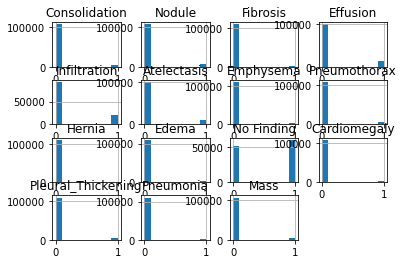

In [7]:
# distribution of diseases
df_labels[labels].hist()

In [8]:
disease = 'Atelectasis'

Fraction of positive class: 0.103


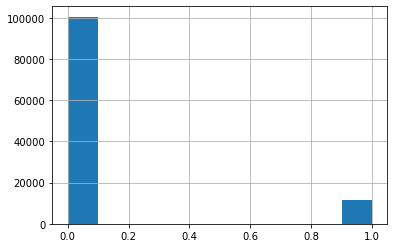

In [9]:
# Label distribution
df_labels.describe(include='all')
df_labels[disease].hist()
print(f"Fraction of positive class: {len(df_labels[df_labels[disease]==1])/len(df_labels):.3f}")

In [10]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_train_val, test_size=0.2,random_state=seed)  # 20% val set, about same size as test

assert len(df_train) + len(df_val) == len(df_train_val)

# Prepare train/val and test data
def select_images(df):
    df = df[df['View Position']=='PA'].reset_index()
    return df

df_train_pa = select_images(df_train)
df_val_pa = select_images(df_val)
df_test_pa = select_images(df_test)

print(f"# train images: {df_train_pa.shape[0]}")
print(f"# val images: {df_val_pa.shape[0]}")
print(f"# test images: {df_test_pa.shape[0]}")

# train images: 44954
# val images: 11260
# test images: 11096


**Warning: The validation images serve as test set. Do NOT use them for model tuning.**
Use leave-out set/CV on training images for tuning instead.

Now we have the images and labels. We can train our model.

In [23]:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# avaiable models in PyTorch: [resnet, alexnet, vgg, squeezenet, densenet, inception]

# this cell must sit above loader, as image resizing inside transform depends on `input_size`.

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ 
        Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ 
        Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ 
        VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ 
        Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ 
        Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

model_name = 'vgg'
num_classes = 2
feature_extract = True

# Initialize the model for this run
model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model)
print(f"Input image size: {input_size}")

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [29]:
# Loader

class NihDataset(Dataset):
    def __init__(self, dataframe, root_dir, label, transform=None):
        """
        label: column name of the label of interest, e.g. 'Pleural Effusion'.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.label = label
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.loc[idx, 'Image Index'])
        # via .getband(), some images are know to have 4 channels.
        # Here we may convert them to 1-channel grayscale or 3-channel RGB depending on the model.
        image = Image.open(img_name).convert('RGB')
        target = self.dataframe.loc[idx, disease]
            
        if self.transform:
            image = self.transform(image)
        
        return image, target
        

In [30]:
# Data loaders to return batch of images
def load_data(dataframe, root_dir, label, transform=None, batch_size=32, shuffle=True, num_workers=4):
    '''
    Data Loader with batch loading and transform.
    '''
    image_data = NihDataset(dataframe, root_dir, label, transform=transform)
    pin = device=='cpu'
    loader = torch.utils.data.DataLoader(image_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin)
    return loader

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),  # data augmentation
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),  # FIXME: how to cater for different `input_size`?
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Define our CNN architecture:

In [31]:
# Define loss function and optimizer

import torch.optim as optim
num_neg = sum(df_train_pa[disease] == 0)
num_pos = sum(df_train_pa[disease] == 1)
assert num_neg + num_pos == len(df_train_pa)
print(f"# of negative/positive cases: {num_neg}:{num_pos}")

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
class_weight = torch.FloatTensor([(1 / num_neg)*(len(df_train_pa))/2.0, (1 / num_pos)*(len(df_train_pa))/2.0]).to(device)
print(f"Class weight: {class_weight}")

#criterion = nn.CrossEntropyLoss()  # change to CrossEntropyLoss if  multiclass
criterion = nn.CrossEntropyLoss(weight=class_weight)  # change to CrossEntropyLoss if  multiclass
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# of negative/positive cases: 41501:3453
Class weight: tensor([0.5416, 6.5094])


In [32]:
def train_model(model, train_loader, valid_loader, num_epochs=10, verbose=True):
    start_time = time.time()
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        print(f"Epoch {epoch+1}")
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor).to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics every 10 batches
            running_loss += loss.item()
            if verbose:
                if i % 10 == 9:    # print every 10 mini-batches
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / (i+1)))
        train_losses.append(running_loss/len(train_data_loader))  # keep trace of train loss in each epoch
        print(f'Time elapsed: {(time.time()-start_time)/60.0:.1f} minutes.')
        
        # validate every epoch
        print("Validating...")
        val_loss, _, _, _ = eval_model(model, valid_loader)
        val_losses.append(val_loss/len(val_data_loader))  # keep trace of validation loss in each epoch
        print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(val_losses[-1]))
        
        # save the model every epoch
        MODEL_PATH = f'../models/simple_net_{time.time()}_epoch{num_epochs}.pth'
        torch.save(model.state_dict(), MODEL_PATH)
        print("Model saved!")
        
    return model, train_losses, val_losses

def eval_model(model, loader):
    from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
    # validate every epoch
    loss = 0.0
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        # empty tensors to hold results
        Y_prob, Y_true, Y_pred = [], [], []
        for inputs, labels in loader:
            probs = model(inputs.to(device)) # prediction probability
            labels = labels.type(torch.LongTensor).to(device)  # true labels
            _, predicted = torch.max(probs, dim=1)
            # stack results
            Y_prob.append(probs[:,-1])  # probability of positive class
            Y_true.append(labels)
            Y_pred.append(predicted)
            
            loss += criterion(probs, labels)

    # convert to numpy
    Y_prob = torch.cat(Y_prob).detach().cpu().numpy()
    Y_pred = torch.cat(Y_pred).detach().cpu().numpy()
    Y_true = torch.cat(Y_true).detach().cpu().numpy()

    # TODO: use desired metrics here
    print(f"ROC: {roc_auc_score(Y_true, Y_prob):.3f}")
    fpr, tpr, _ = roc_curve(Y_true, Y_prob)
    auc = roc_auc_score(Y_true, Y_prob)
    plt.figure()
    plt.plot(fpr,tpr,label=f"Validation, ROCAUC={auc:3f}")
    plt.legend(loc=4)
    plt.show()
    
    print(classification_report(Y_true, Y_pred))
    plt.figure()
    cm = confusion_matrix(Y_true, Y_pred)  # confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
     
    return loss, Y_prob, Y_pred, Y_true

In [33]:
#loss, Y_prob, Y_pred, Y_true = eval_model(model, val_data_loader)

In [34]:
#pd.DataFrame(Y_prob).hist()

In [ ]:
import time

num_epochs = 10
batch_size = 256

train_data_loader = load_data(df_train_pa, DATA_FOLDER, disease, transform=data_transforms['train'], shuffle=True, batch_size=batch_size)
val_data_loader = load_data(df_val_pa, DATA_FOLDER, disease, transform=data_transforms['test'], shuffle=False, batch_size=32)

print(f"Training start. Mode: {device}")
start_time = time.time()
model, t_losses, v_losses = train_model(model, train_data_loader, val_data_loader, num_epochs=num_epochs, verbose=False)
print(f'Finished Training. Total time: {time.time()-start_time} secs.')

Training start. Mode: cpu
Epoch 1


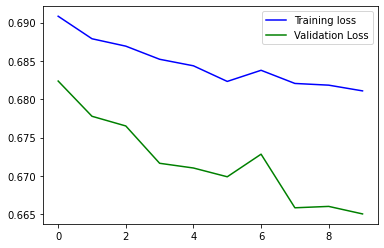

In [22]:
# plot training and validation loss over epoches
plt.figure()
plt.plot(t_losses, 'b', label='Training loss')
plt.plot(v_losses, 'g', label='Validation Loss')
plt.legend()
plt.show()

ROC: 0.551


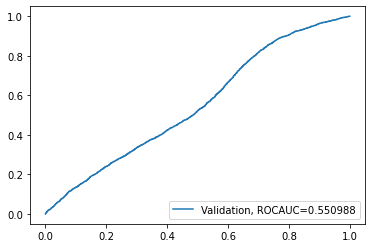

              precision    recall  f1-score   support

           0       0.58      0.66      0.62      6291
           1       0.45      0.37      0.41      4805

    accuracy                           0.53     11096
   macro avg       0.52      0.51      0.51     11096
weighted avg       0.52      0.53      0.53     11096



<Figure size 432x288 with 0 Axes>

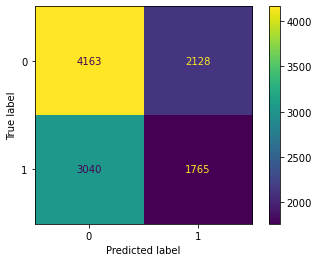

In [23]:
# Evaluate on test set
test_data_loader = load_data(df_test_pa, DATA_FOLDER, disease, transform=data_transforms['test'], shuffle=False, batch_size=32)
test_loss, t_prob, t_pred, t_true = eval_model(model, test_data_loader)